Importing Necessary Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from copy import copy
# import talib as ta

Loading Data

In [2]:
stonks='SPY,AAPL,IBM,GS,GOOG,GM,AMZN,BP'
stk=yf.download(stonks,start='2001-1-1')
close=stk['Close']
volume=stk['Volume']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  8 of 8 completed


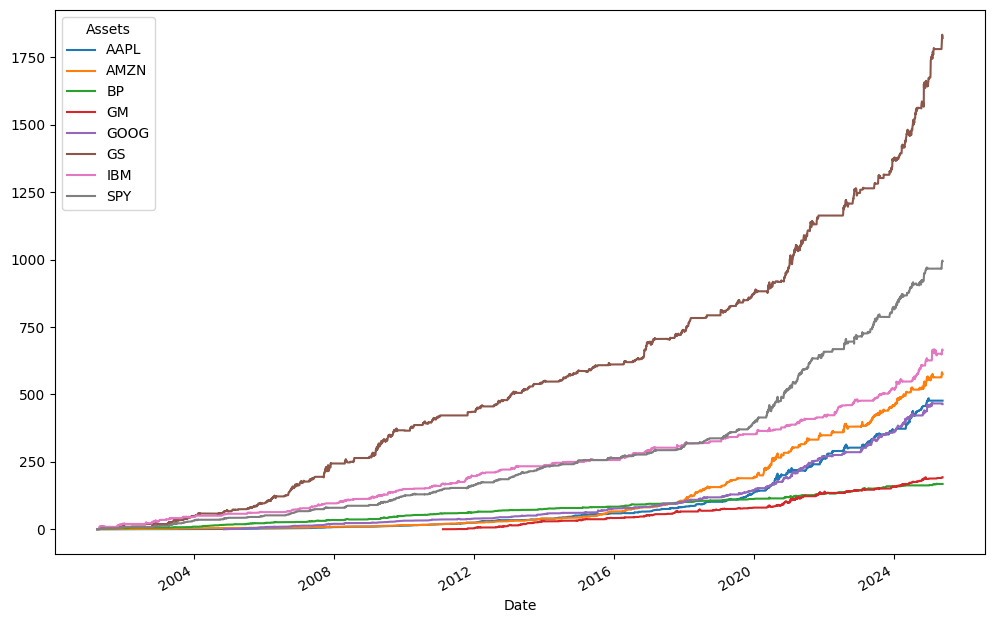

In [54]:
# Checking side of trade and computing returns in dollar amount
side=((np.sign(close-(1.03*close.rolling(60).mean())))+1)/2

rets=np.cumsum(close.diff()*side.shift(-1))

rets.plot(figsize=(12,8))
plt.legend(title="Assets", loc="best")
plt.show()

### I am using log(close) because from 2001 to 2025, prices have increased a lot, so to keep them normalized I took log of them.
#### This wont have any effect on backtest or return, just that they will be scaled down

In [55]:
def backtest(x,a):
    return (x-(1.03*x.rolling(a).mean()))/(x.rolling(a).mean())

Momentum=backtest(close,60)
Momentum

Ticker,AAPL,AMZN,BP,GM,GOOG,GS,IBM,SPY
Date,,,,,,,,
2001-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2025-05-15,-0.042435,0.028001,-0.054993,0.035210,-0.019648,0.081406,0.057465,0.025336
2025-05-16,-0.040685,0.031744,-0.048635,0.039538,-0.005266,0.087729,0.057513,0.032475
2025-05-19,-0.049509,0.035644,-0.058397,0.030870,-0.001156,0.075917,0.063596,0.033741


In [56]:
N=3
np.argsort(Momentum,axis=1)

array([[0, 1, 2, ..., 5, 6, 7],
       [0, 1, 2, ..., 5, 6, 7],
       [0, 1, 2, ..., 5, 6, 7],
       ...,
       [2, 0, 4, ..., 1, 6, 5],
       [2, 0, 4, ..., 3, 6, 5],
       [0, 2, 1, ..., 4, 6, 5]])

In [57]:
rets=(pd.DataFrame(np.argsort(Momentum,axis=1),index=Momentum.index,columns=Momentum.columns)<3)*close.pct_change().shift(-1)*-1

rets_2=np.mean(rets,axis=1)
rets_2
#pd.DataFrame(np.argsort(Momentum,axis=1),index=Momentum.index,columns=Momentum.columns)>len(Momentum.columns)-4

,0
Date,
2001-01-02,-0.058531
2001-01-03,0.012575
2001-01-04,0.013968
2001-01-05,-0.005986
2001-01-08,-0.016973
...,...
2025-05-15,-0.001678
2025-05-16,0.001965
2025-05-19,0.003597


In [58]:
# Momentum=close.apply(lambda x:ta.MOM(x,30))
Momentum

Ticker,AAPL,AMZN,BP,GM,GOOG,GS,IBM,SPY
Date,,,,,,,,
2001-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2025-05-15,-0.042435,0.028001,-0.054993,0.035210,-0.019648,0.081406,0.057465,0.025336
2025-05-16,-0.040685,0.031744,-0.048635,0.039538,-0.005266,0.087729,0.057513,0.032475
2025-05-19,-0.049509,0.035644,-0.058397,0.030870,-0.001156,0.075917,0.063596,0.033741


In [111]:
def returns_Momentum(N):
  bottom_stocks=(np.argsort(Momentum,axis=1)<N)
  top_stocks=(np.argsort(Momentum,axis=1)>=len(close.columns)-N)

  rets_bottom=((bottom_stocks*close.pct_change().shift(-1)).sum(axis=1)/N)
  rets_top=((top_stocks*close.pct_change().shift(-1)).sum(axis=1)/N)
  return rets_bottom,rets_top

In [122]:
rets_low,rets_high=returns_Momentum(3)

<Axes: xlabel='Date'>

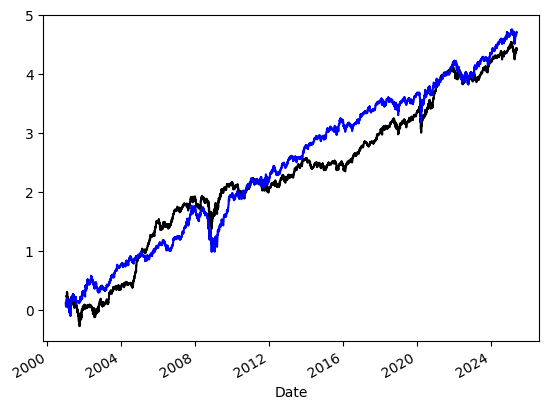

In [123]:
''' Not taking compounding in effect as a lot of traders don't necessarily
    reinvest entire profits. using cumsum() will help us get a realistic
    view of returns without overestimating it '''
(rets_low).cumsum().plot(label='Low Momentum',color='k')
(rets_high).cumsum().plot(label='High Momentum',color='b')

Text(0.5, 1.0, 'Top 2 stocks')

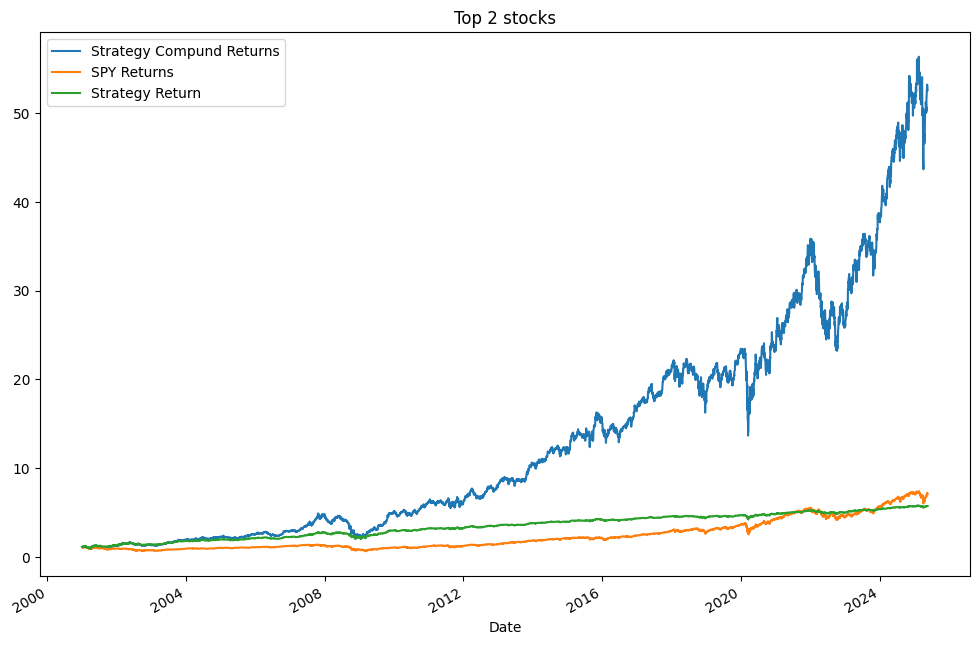

In [124]:
rets_spy=close.SPY.pct_change()
SPY_rets=(1+rets_spy).cumprod()
strat_compound_rets=(1+rets_high).cumprod()
strat_rets=(rets_high).cumsum()
strat_rets=strat_rets+1

returns=pd.DataFrame(
    {
        "Strategy Compund Returns":strat_compound_rets,
        "SPY Returns": SPY_rets,
        "Strategy Return": strat_rets
    }
)

returns.plot(figsize=(12,8));
plt.title("Top 2 stocks")

Text(0.5, 1.0, 'Bottom 2 Stocks')

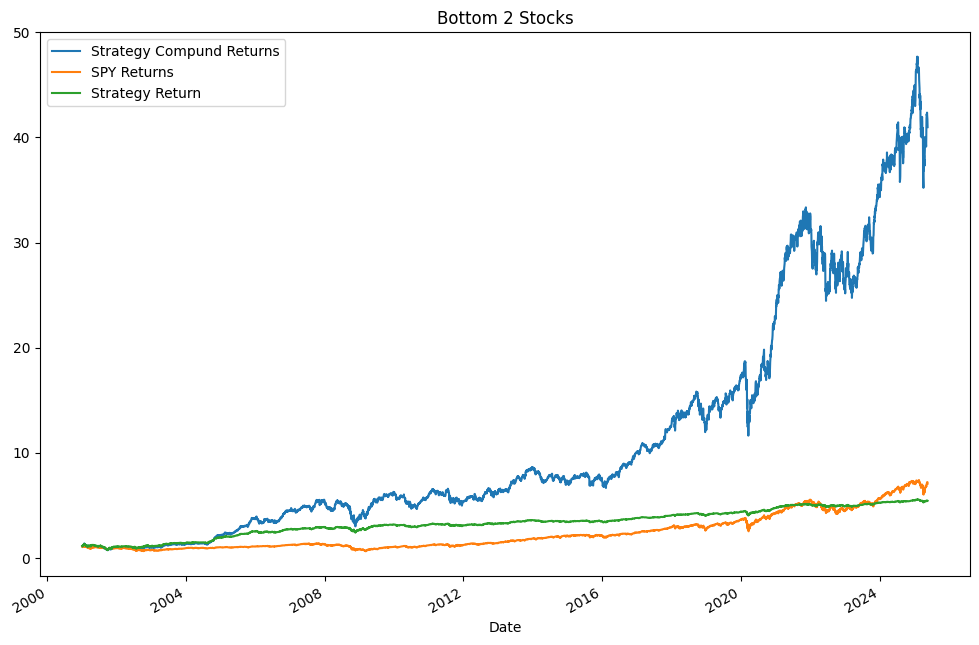

In [125]:
rets_spy=close.SPY.pct_change()
SPY_rets=(1+rets_spy).cumprod()
strat_compound_rets=(1+rets_low).cumprod()
strat_rets=(rets_low).cumsum()
strat_rets=strat_rets+1

returns=pd.DataFrame(
    {
        "Strategy Compund Returns":strat_compound_rets,
        "SPY Returns": SPY_rets,
        "Strategy Return": strat_rets
    }
)
returns.plot(figsize=(12,8));
plt.title("Bottom 2 Stocks")

In [116]:
def metrics(x):
  Sharpe=np.mean(x)/np.std(x)*np.sqrt(252)
  sortino=np.mean(x)/np.std(x[x<=0])*np.sqrt(252)
  return Sharpe,sortino

In [126]:
sharpe_l,sortino_l=metrics(rets_low)
sharpe_h,sortino_h=metrics(rets_high)
print(f"Sharpe_low: {sharpe_l}",f"Sortino_low: {sortino_l}")
print(f"Sharpe_high: {sharpe_h}",f"Sortino_high: {sortino_h}")

Sharpe_low: 0.7563899045782017 Sortino_low: 1.0297124327587095
Sharpe_high: 0.7802878416154885 Sortino_high: 1.0762883028772292


In [129]:
rets=rets_high+rets_low
sharpe_lh,sortino_lh=metrics(rets)
sharpe_lh,sortino_lh

(np.float64(0.8578088841929763), np.float64(1.1611646281945442))